# Approach

1. > compare Embeddings (```minorminer```) and choose the best
1. > compare Chain Settings and choose the best
1. > compare Anneal Times and choose the best
1. > compare Anneal Schedules and choose the best

## QUBO

### Imports

In [1]:
import sys
sys.path.append("..")
from qubo_util import *

import dimod
import numpy as np
import pandas as pd
import dwave.inspector
import matplotlib.pyplot as plt
from dwave.system.samplers import DWaveSampler
from dwave.embedding.chain_strength import scaled, uniform_torque_compensation
from dwave.system import DWaveSampler, FixedEmbeddingComposite, EmbeddingComposite

### Config

In [2]:
from dwave.cloud import Client
client = Client.from_config(config_file='/Users/jonas/Library/Application Support/dwave/dwave.conf')

### Jobs

In [3]:
### Lets define the basics

bend = [0, 1, 2]
weld = [3, 4]
paint =  [5]

bend_length = 2
weld_length = 3
paint_length = 6

t_step = 3
t_step_in_sec = 30

In [4]:
jobs = [(0, 0, 1, 2, 1, 3),
 (1, 0, 0, 2, 0, 1)]

In [5]:
# OrderNo, PartNo, BendingLines, WeldingPoints, PaintTime, DueDate 

m_t_steps = max_time(jobs, bend_length, weld_length, paint_length)

m_time = m_t_steps * t_step_in_sec
    
print('The maximal maketime for the given operations is: ' + str(m_time) + ' second(s).\nWhich is equal to: ' + str(m_t_steps) + ' time steps.\n\n')

The maximal maketime for the given operations is: 420 second(s).
Which is equal to: 14 time steps.




In [6]:
operations = ops(jobs, bend, weld, paint, bend_length, weld_length, paint_length, t_step)

print('Anzahl an Kombinationen: ' + str(len(operations)) + '\n')

Anzahl an Kombinationen: 12



### Parameters

In [7]:
alpha = 2
beta = 1.5
gamma = 2
delta = 0.035

QUBO = get_QUBO(jobs, operations, alpha, beta, gamma, delta, bend_length, weld_length, paint_length, bend, weld, paint)
qubo_dictionary = qubo_to_dictionary_ohne_null(QUBO, operations)


# Run

## Get Embedding with ```  minorminer  ``` as part of EmbeddingComposite() and safe it

https://docs.dwavesys.com/docs/latest/handbook_embedding.html#example-clique-embedding-a-sparse-bqm

https://docs.dwavesys.com/docs/latest/handbook_qpu.html?highlight=sampleset_1#read-anneal-cycles

In [8]:
bqm = dimod.BinaryQuadraticModel.from_numpy_matrix(QUBO)
qpu = DWaveSampler(solver={'topology__type': 'pegasus'})

In [9]:
# Each run with 500 shots (more runs with less shots yield better results than less runs with more shots)
numr = 500

# Chain Strength = Max(QUBO) // Analog zur D Wave Dokumentation

chnstr = find_chstr(QUBO)+1

# Empty array
data=[]

### And Visualize embedding,  check for Chain Breaks and run inspection with ```dwave.inspector.```

#### First Embedding

In [11]:
sampler = EmbeddingComposite(qpu)
sampleset1A = sampler.sample(bqm, 
                           return_embedding=True, 
                           answer_mode="raw", 
                           num_reads=numr, 
                           chain_strength= chnstr)
embedding1 = sampleset1A.info["embedding_context"]["embedding"]  
chains = sampleset1A.info["embedding_context"]["embedding"].values()  

In [12]:
analyze(sampleset1A, "embedding1A", data)

Good solutions are 42.0% of samples.
Best Known solutions are 16.8% of samples.
Lowest energy found: [-8.0]
Average energy is -6.25 with standard deviation 1.90


In [13]:
sampleset1B = FixedEmbeddingComposite(qpu, embedding1).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)

In [14]:
analyze(sampleset1B, "embedding1B", data)

Good solutions are 45.6% of samples.
Best Known solutions are 18.4% of samples.
Lowest energy found: [-8.0]
Average energy is -6.30 with standard deviation 2.10


In [16]:
print(sampleset1A.info["embedding_context"]["chain_strength"])    

9.0


In [17]:
print(max(len(chain) for chain in chains))   

2


In [19]:
print("Percentage of samples with >10% breaks is {} and >0 is {}.".format(np.count_nonzero(sampleset1A.record.chain_break_fraction > 0.10)/numr*100, np.count_nonzero(sampleset1A.record.chain_break_fraction > 0.0)/numr*100))


Percentage of samples with >10% breaks is 0.0 and >0 is 0.0.


In [34]:
# Inspect Embedding
dwave.inspector.show(sampleset1A)

'http://127.0.0.1:18000/?problemId=92b08c25-72dc-454e-97dc-7cc64c8b6829'

#### Second Embedding

In [20]:
sampler = EmbeddingComposite(qpu)
sampleset2A = sampler.sample(bqm, 
                           return_embedding=True, 
                           answer_mode="raw", 
                           num_reads=numr, 
                           chain_strength= chnstr)
embedding2 = sampleset2A.info["embedding_context"]["embedding"]  
chains = sampleset2A.info["embedding_context"]["embedding"].values()  


In [21]:
analyze(sampleset2A, "embedding2A", data)

Good solutions are 48.2% of samples.
Best Known solutions are 14.6% of samples.
Lowest energy found: [-8.0]
Average energy is -6.42 with standard deviation 1.88


In [22]:
sampleset2B = FixedEmbeddingComposite(qpu, embedding2).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)

In [23]:
analyze(sampleset2B, "embedding2B", data)

Good solutions are 46.2% of samples.
Best Known solutions are 13.4% of samples.
Lowest energy found: [-8.0]
Average energy is -6.29 with standard deviation 2.00


In [24]:

print(sampleset2A.info["embedding_context"]["chain_strength"])    

9.0


In [25]:
print(max(len(chain) for chain in chains))   

2


In [26]:
print("Percentage of samples with >10% breaks is {} and >0 is {}.".format(np.count_nonzero(sampleset2A.record.chain_break_fraction > 0.10)/numr*100, np.count_nonzero(sampleset2A.record.chain_break_fraction > 0.0)/numr*100))


Percentage of samples with >10% breaks is 0.0 and >0 is 0.0.


In [ ]:
# Inspect Embedding
dwave.inspector.show(sampleset2A) 

#### Third Embedding

In [27]:
sampler = EmbeddingComposite(qpu)
sampleset3A = sampler.sample(bqm, 
                           return_embedding=True, 
                           answer_mode="raw", 
                           num_reads=numr, 
                           chain_strength= chnstr)
embedding3 = sampleset3A.info["embedding_context"]["embedding"]  
chains = sampleset3A.info["embedding_context"]["embedding"].values()  


In [28]:
analyze(sampleset3A, "embedding3A", data)

Good solutions are 41.0% of samples.
Best Known solutions are 20.0% of samples.
Lowest energy found: [-8.0]
Average energy is -6.13 with standard deviation 2.09


In [29]:
sampleset3B = FixedEmbeddingComposite(qpu, embedding3).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)

In [30]:
analyze(sampleset3B, "embedding3B", data)

Good solutions are 45.2% of samples.
Best Known solutions are 15.0% of samples.
Lowest energy found: [-8.0]
Average energy is -6.17 with standard deviation 2.22


In [31]:

print(sampleset3A.info["embedding_context"]["chain_strength"])    

9.0


In [32]:
print(max(len(chain) for chain in chains))   

2


In [33]:
print("Percentage of samples with >10% breaks is {} and >0 is {}.".format(np.count_nonzero(sampleset3A.record.chain_break_fraction > 0.10)/numr*100, np.count_nonzero(sampleset3A.record.chain_break_fraction > 0.0)/numr*100))


Percentage of samples with >10% breaks is 0.0 and >0 is 0.0.


In [ ]:
# Inspect Embedding
dwave.inspector.show(sampleset3) 

## Chain Management for best Embedding

In [35]:
# Choose best Embedding 
embedding = 

### Adjust Chain Strength if necessary 

The following considerations and recommendations apply to chains.

- Prefer short chains to long chains.
- Prefer uniform chain lengths to uneven chains.
- Balance chain strength and problem range. Estimate chain strength and set just slightly above the minimum threshold needed, using strategies for auto-adjusting these chains. 

##### run again with each chain setting

In [36]:
# Default
sampleset_default = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)


In [37]:
analyze(sampleset_default, "default_chains", data)

Good solutions are 39.8% of samples.
Best Known solutions are 14.2% of samples.
Lowest energy found: [-8.0]
Average energy is -5.66 with standard deviation 2.79


You can set a chain strength relative to your problem’s largest bias by using, for example, the scaled() function.

In [38]:
chnstr = scaled

In [39]:
#from dwave.embedding.chain_strength import scaled
sampleset_scaled1 = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)  


In [40]:
analyze(sampleset_scaled1, "scaled_chains1", data)

Good solutions are 37.0% of samples.
Best Known solutions are 19.4% of samples.
Lowest energy found: [-8.0]
Average energy is -5.50 with standard deviation 2.78


In [41]:
#from dwave.embedding.chain_strength import scaled
sampleset_scaled2 = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)  


In [42]:
analyze(sampleset_scaled2, "scaled_chains2", data)

Good solutions are 29.4% of samples.
Best Known solutions are 11.8% of samples.
Lowest energy found: [-8.0]
Average energy is -4.75 with standard deviation 3.43


Chain strength that attempts to compensate for torque that would break the chain.

In [43]:
chnstr = uniform_torque_compensation

In [44]:
#from dwave.embedding.chain_strength import uniform_torque_compensation
sampleset_torque1 = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)  


In [45]:
analyze(sampleset_torque1, "torque_chains1", data)

Good solutions are 67.0% of samples.
Best Known solutions are 26.8% of samples.
Lowest energy found: [-8.0]
Average energy is -7.08 with standard deviation 1.46


In [46]:
#from dwave.embedding.chain_strength import uniform_torque_compensation
sampleset_torque2 = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)  


In [47]:
analyze(sampleset_torque2, "torque_chains2", data)

Good solutions are 61.0% of samples.
Best Known solutions are 19.6% of samples.
Lowest energy found: [-8.0]
Average energy is -6.86 with standard deviation 1.62


## Run for different Times and Schedules

In [48]:
# With optimal chain strengths:
chnstr = 

https://docs.dwavesys.com/docs/latest/handbook_qpu.html?highlight=anneal_schedule#annealing-schedule

https://docs.dwavesys.com/docs/latest/c_qpu_0.html?highlight=quench

In [49]:
#qpu.properties["default_annealing_time"]      
# 20

### Find Sweet Spot for Annealing Time

In [50]:
#10
sampleset_10 = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
                                                              return_embedding=True, 
                                                              answer_mode="raw", 
                                                              num_reads=numr, 
                                                              chain_strength= chnstr,
                                                              annealing_time=10)  


In [51]:
analyze(sampleset_10, "time_10", data)

Good solutions are 63.8% of samples.
Best Known solutions are 25.0% of samples.
Lowest energy found: [-8.0]
Average energy is -7.05 with standard deviation 1.34


In [52]:
#15
sampleset_15 = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
                                                              return_embedding=True, 
                                                              answer_mode="raw", 
                                                              num_reads=numr, 
                                                              chain_strength= chnstr,
                                                              annealing_time=15)


In [53]:
analyze(sampleset_15, "time_15", data)

Good solutions are 63.0% of samples.
Best Known solutions are 27.6% of samples.
Lowest energy found: [-8.0]
Average energy is -7.03 with standard deviation 1.34


In [54]:
#20
sampleset_20 = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
                                                              return_embedding=True, 
                                                              answer_mode="raw", 
                                                              num_reads=numr, 
                                                              chain_strength= chnstr,
                                                              annealing_time=20)

In [55]:
analyze(sampleset_20, "time_20", data)

Good solutions are 70.2% of samples.
Best Known solutions are 27.6% of samples.
Lowest energy found: [-8.0]
Average energy is -7.18 with standard deviation 1.32


In [56]:
#25
sampleset_25 = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
                                                              return_embedding=True, 
                                                              answer_mode="raw", 
                                                              num_reads=numr, 
                                                              chain_strength= chnstr,
                                                              annealing_time=25)

In [57]:
analyze(sampleset_25, "time_25", data)

Good solutions are 76.4% of samples.
Best Known solutions are 28.0% of samples.
Lowest energy found: [-8.0]
Average energy is -7.37 with standard deviation 1.05


In [58]:
#30
sampleset_30 = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
                                                              return_embedding=True, 
                                                              answer_mode="raw", 
                                                              num_reads=numr, 
                                                              chain_strength= chnstr,
                                                              annealing_time=30)

In [59]:
analyze(sampleset_30, "time_30", data)

Good solutions are 69.0% of samples.
Best Known solutions are 21.2% of samples.
Lowest energy found: [-8.0]
Average energy is -7.17 with standard deviation 1.23


### Find best Schedule

### Pause and Quench

<img src="https://docs.dwavesys.com/docs/latest/_images/16q-pause.png" alt="drawing" width="600"/>

First verify the quench schedule

##### run with best chain setting twice

In [60]:
quench_schedule = [[0.0, 0.0], [15.0, 0.4], [215.0, 0.4], [230, 1.0]]

# [[t, s], [t_1, s_1], ..., [t_n, s_n]]
# Time t must increase for all points in the schedule.
# the anneal fraction s must start at s = 0.0 and end at s = 1.0

In [61]:
sampleset_quench1 = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                  answer_mode="raw", 
                                                                  num_reads=numr, 
                                                                  chain_strength= chnstr,
                                                                  anneal_schedule=quench_schedule)  


In [62]:
analyze(sampleset_quench1, "quench_schedule1", data)

Good solutions are 75.0% of samples.
Best Known solutions are 30.2% of samples.
Lowest energy found: [-8.0]
Average energy is -7.37 with standard deviation 1.00


In [63]:
sampleset_quench2 = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                  answer_mode="raw", 
                                                                  num_reads=numr, 
                                                                  chain_strength= chnstr,
                                                                  anneal_schedule=quench_schedule)  


In [64]:
analyze(sampleset_quench2, "quench_schedule2", data)

Good solutions are 77.6% of samples.
Best Known solutions are 29.0% of samples.
Lowest energy found: [-8.0]
Average energy is -7.37 with standard deviation 1.21


### Reverse

In brief, reverse annealing is a technique that makes it possible to refine known good local solutions, thereby increasing performance for certain applications.

There are three parameters you can use to configure reverse annealing using Ocean:

1. `anneal_schedule` defines the annealing schedule that should be followed.
2. `initial_state` specifies the classical state at which the reverse anneal should start.
3. `reinitialize_state` specifies whether or not the initial state should be used for every anneal in the request.  If False, then after the first, each subsequent anneal starts where the previous finished.

<img src="https://docs.dwavesys.com/docs/latest/_images/ra.png" alt="drawing" width="600"/>


A Reverse schedule always starts at `s = 1.0`, and ours reverses quickly to `s = 0.45`, pauses for `100 μs`, then quickly anneals forward. The schedule is formatted as a list of  **[time, s]** pairs. The next cell plots the schedule.

In [102]:
# [[t, s], [t_1, s_1], ..., [t_n, s_n]]
# Time t must increase for all points in the schedule.
# the anneal fraction s must start and end at s = 1.0
max_slope = 1.0/qpu.properties["annealing_time_range"][0]
reverse_schedule = make_reverse_anneal_schedule(s_target=0.45, hold_time=100, ramp_up_slope=max_slope)
time_total = reverse_schedule[3][0]

print(reverse_schedule)
print("Total anneal-schedule time is {} us".format(time_total))

[[0.0, 1.0], [2.75, 0.45], [102.75, 0.45], [103.3, 1.0]]
Total anneal-schedule time is 103.3 us


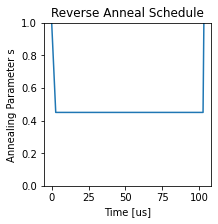

In [103]:
make_anneal_plot(reverse_schedule)

In [95]:
# Assign best Sampleset
best_sampleset = 

In [104]:

i5 = int(5.0/95*len(best_sampleset))  # Index i5 is about a 5% indexial move from the sample of lowest energy

initial = dict(zip(best_sampleset.variables, best_sampleset.record[i5].sample))
reverse_anneal_params = dict(anneal_schedule=reverse_schedule, initial_state=initial, reinitialize_state=False)

# The `reinitialize_state` parameter switches between two qualitatively different methods of local search 
# via quantum annealing.  With `reinitialize_state = 'True'`, many anneals are seeded from the single starting 
# state and the states returned, modulo time-dependent sources of error, are independently and identically 
# distributed.  With `reinitialize_state = 'False'`, the series of anneals behaves like a random walk and 
# is capable of exploring the solution space more broadly.  


In [105]:
sampleset_reverse1 = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr,
                                                                   **reverse_anneal_params)  


In [106]:
analyze(sampleset_reverse1, "reverse_schedule1", data)

Good solutions are 66.2% of samples.
Best Known solutions are 28.4% of samples.
Lowest energy found: [-8.0]
Average energy is -7.08 with standard deviation 1.43


In [107]:
sampleset_reverse2 = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr,
                                                                   **reverse_anneal_params)  


In [108]:
analyze(sampleset_reverse2, "reverse_schedule2", data)

Good solutions are 64.2% of samples.
Best Known solutions are 28.4% of samples.
Lowest energy found: [-8.0]
Average energy is -7.00 with standard deviation 1.48


#### Make table of solutions:

In [109]:
df = pd.DataFrame(data, columns=["Label", "Best Known Solutions (%)", "Good Known Solutions (%)", "Lowest Energy", "Average Energy", "Standard Deviation"])
df

,Label,Best Known Solutions (%),Good Known Solutions (%),Lowest Energy,Average Energy,Standard Deviation
0,embedding1A,16.8,42.0,-8.0,-6.25495,1.895956
1,embedding1B,18.4,45.6,-8.0,-6.30209,2.097576
2,embedding2A,14.6,48.2,-8.0,-6.41688,1.880962
3,embedding2B,13.4,46.2,-8.0,-6.29079,2.004524
4,embedding3A,20.0,41.0,-8.0,-6.12991,2.086590
5,embedding3B,15.0,45.2,-8.0,-6.16972,2.220930
6,default_chains,14.2,39.8,-8.0,-5.66342,2.788737
7,scaled_chains1,19.4,37.0,-8.0,-5.50420,2.785000
8,scaled_chains2,11.8,29.4,-8.0,-4.75229,3.426431
9,torque_chains1,26.8,67.0,-8.0,-7.07897,1.460644
